In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Cambiar directorio
os.chdir("..")

In [3]:
# Cargar los datos que tenemos disponibles
data = pd.read_csv("data/churn.csv")


In [4]:
data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
# Nos deshacemos de las columnas que no contribuyen en mucho
data = data.drop(data.columns[0:3], axis=1)

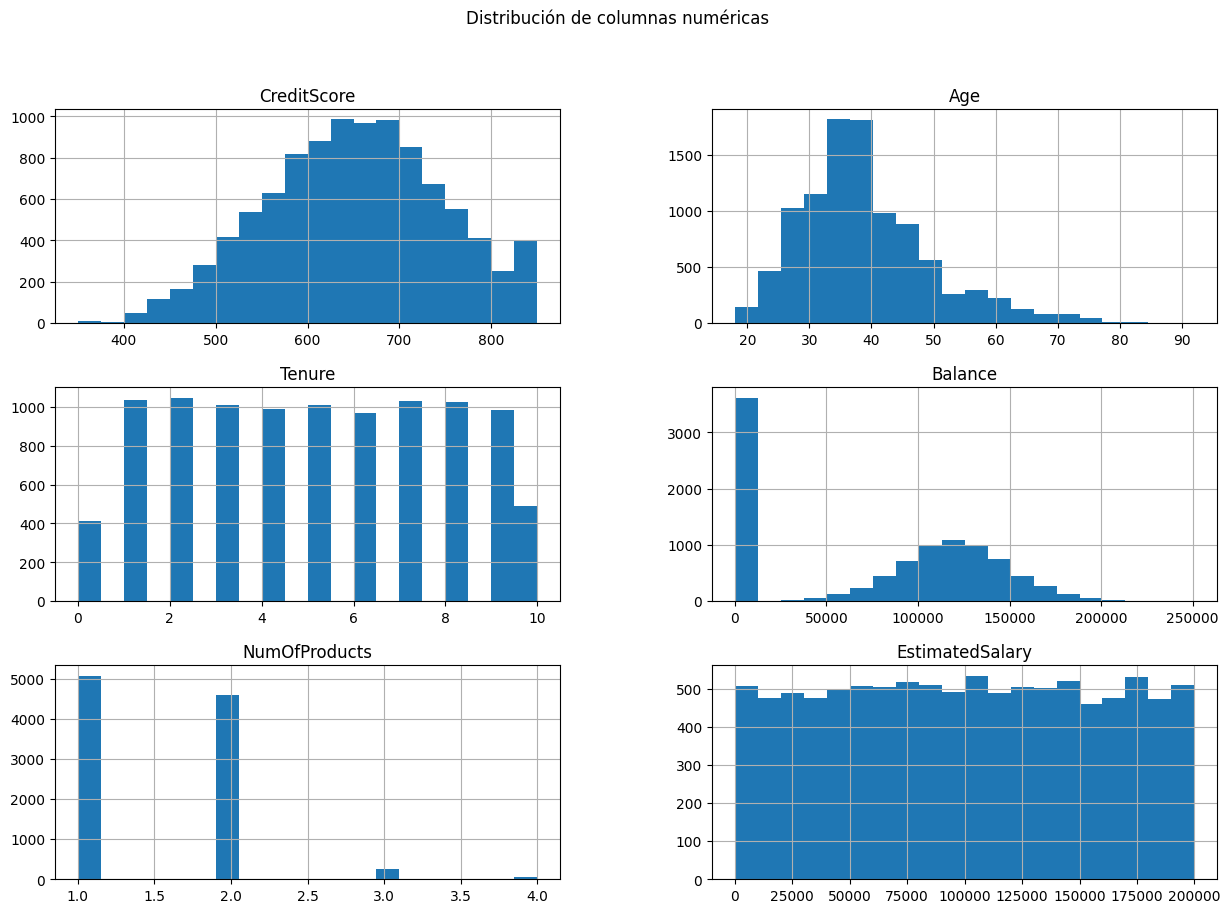

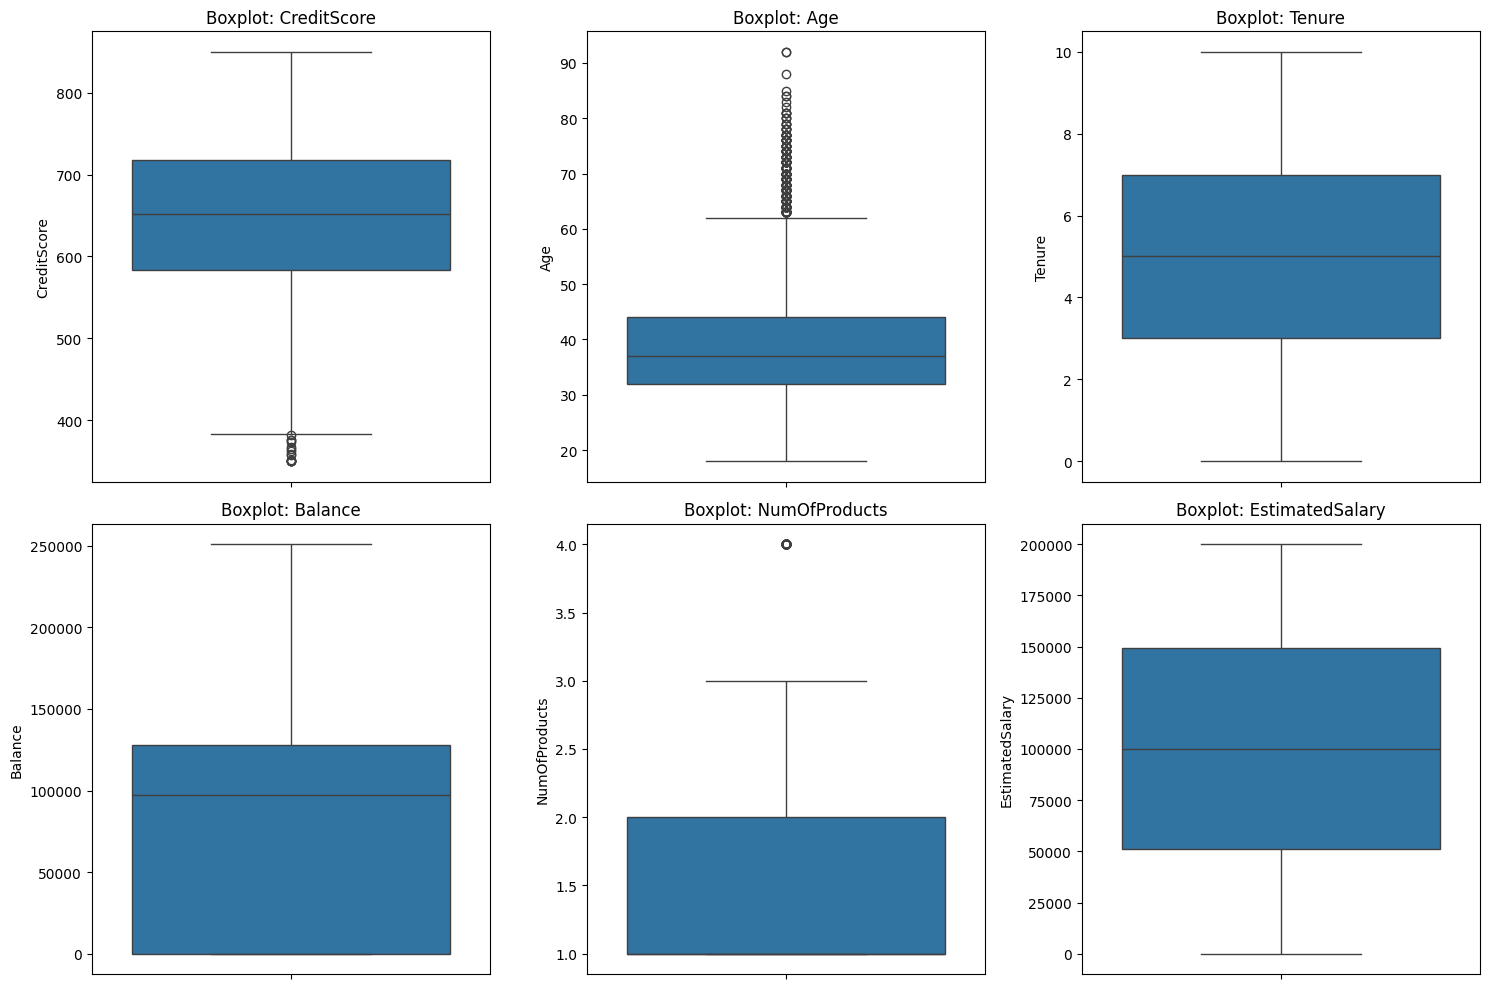

In [6]:
# Visualización de las columnas numéricas
numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

# Histograma de las columnas numéricas
data[numerical_columns].hist(bins=20, figsize=(15, 10))
plt.suptitle("Distribución de columnas numéricas")
plt.show()

# Boxplot para detectar outliers en las columnas numéricas
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data[col])
    plt.title(f"Boxplot: {col}")
plt.tight_layout()
plt.show()

In [7]:
# Crear una nueva columna que indica si el cliente tiene saldo o no
data['HasBalance'] = (data['Balance'] > 0).astype(int)

# Mostrar la nueva columna para verificar
print(data[['Balance', 'HasBalance']].head())



     Balance  HasBalance
0       0.00           0
1   83807.86           1
2  159660.80           1
3       0.00           0
4  125510.82           1


In [8]:
# Eliminar las filas que contienen valores nulos
data_cleaned = data.dropna()

# Verificar cuántas filas y columnas quedan después de la limpieza
print(data_cleaned.shape)

(10000, 12)


In [9]:
# Aplicar One Hot Encoding
data_encoded = pd.get_dummies(data, drop_first=True)

# Convertir las columnas booleanas a 1 y 0
data_encoded = data_encoded.astype(int)


In [33]:
#column_equivalence

{1: {'France': 0, 'Germany': 1, 'Spain': 2}, 2: {'Female': 0, 'Male': 1}}

In [ ]:
# Vamos a crear un modelo de regresion logistica
#from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LogisticRegression


In [28]:
# Generar los datos para poder separar la variable de respuesta de los datos que tenemos disponibles
#X = data.copy()
#y = X.pop(data.columns[-1])

In [10]:
# Generar los datos para poder separar la variable de respuesta de los datos que tenemos disponibles
X = data_encoded.copy()  # Usamos los datos procesados (con One Hot Encoding)
y = X.pop('Exited')  # Extraemos la columna 'Exited' como variable objetivo

In [11]:
# Separar los datos en datos de entrenamiento y testing
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

In [12]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report

# Crear el modelo de XGBoost
clf_xgb = xgb.XGBClassifier(random_state=0, n_estimators=100, learning_rate=0.05, scale_pos_weight=2)

# Entrenar el modelo
clf_xgb.fit(X_train, y_train)

# Predecir
y_pred = clf_xgb.predict(X_test)

# Evaluar
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[2436  221]
 [ 248  395]]
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2657
           1       0.64      0.61      0.63       643

    accuracy                           0.86      3300
   macro avg       0.77      0.77      0.77      3300
weighted avg       0.86      0.86      0.86      3300



In [19]:
# Crear el modelo de regresión logística y entrenarlo
clf_lin = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
clf_lin.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', random_state=0)

In [ ]:
# Predecir con el conjunto de testing
y_pred = clf_lin.predict(X_test)

In [23]:
# Mostrar la matriz de confusión para evaluar el modelo
conf_matrix = confusion_matrix(y_test, y_pred)

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(conf_matrix)

Matriz de Confusión:
[[2592   65]
 [ 590   53]]


In [31]:
# Medir los resultados obtenidos
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, clf_lin.predict(X_test))


array([[2599,   58],
       [ 597,   46]])

In [14]:
import pickle

# 1. Guardar el modelo entrenado (clf_xgb)
pickle.dump(clf_xgb, open("churn/models/model.pk", "wb"))

# 2. Guardar la equivalencia de las columnas (si la tienes o la puedes generar)
# Si no tienes column_equivalence, crea una según lo que necesites
column_equivalence = {}  # Aquí debes definir las equivalencias si las tienes (por ejemplo, las columnas antes de One Hot Encoding)
pickle.dump(column_equivalence, open("churn/models/column_equivalence.pk", "wb"))

# 3. Guardar las características (en este caso, las columnas numéricas y las categóricas después del One Hot Encoding)
features = numerical_columns + [col for col in data_encoded.columns if col not in numerical_columns]  # Incluye las columnas transformadas
pickle.dump(features, open("churn/models/features.pk", "wb"))

In [ ]:
# Generar el binario del modelo para reutilizarlo, equivalencia de variables categoricas y caracteristicas del modelo
import pickle
pickle.dump(clf_lin, open("churn/models/model.pk", "wb"))
pickle.dump(column_equivalence, open("churn/models/column_equivalence.pk", "wb"))
pickle.dump(features, open("churn/models/features.pk", "wb"))